In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [2]:
from pathlib import Path
from fastai.vision import *
import wandb
from wandb.fastai import WandbCallback
from functools import partialmethod

In [ ]:
wandb.init(project="semantic-segmentation")

In [4]:
config = wandb.config           # for shortening
config.framework = "fast.ai"    
config.img_size = (360, 640)    # dimensions of resized image - can be 1 dim or tuple
config.batch_size = 1           # Batch size during training
config.epochs = 20              # Number of epochs for training
encoder = models.resnet18       
config.encoder = encoder.__name__
config.pretrained = True       
config.weight_decay = 1e-4      # weight decay applied on layers
config.bn_weight_decay = False  
config.one_cycle = True        
config.learning_rate = 3e-3     # learning rate
save_model = True

In [5]:
config.training_stages = 2
path_data = Path('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg')
path_lbl = path_data / 'labels'
path_img = path_data / 'images'

get_y_fn = lambda x: path_lbl / x.parts[-2] / f'{x.stem}_train_id.png'

In [6]:
segmentation_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
void_code = 19

In [8]:
src = (SegmentationItemList.from_folder(path_img).use_partial_data(0.01)
       .split_by_folder(train='train', valid='val')
       .label_from_func(get_y_fn, classes=segmentation_classes))
data = ImageDataBunch.from_folder('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images', train='/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train', test='/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/test', valid = '/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/val', valid_pct=0.2, ds_tfms=get_transforms(), size=224)


/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:458: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [9]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()
    
learn = unet_learner(
data,arch=encoder,
pretrained=config.pretrained,
metrics=acc,
wd=config.weight_decay,
bn_wd=config.bn_weight_decay,
callback_fns=partial(WandbCallback, save_model=save_model, monitor='acc', input_type='images'))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [10]:
if config.one_cycle:
    learn.fit_one_cycle(
        config.epochs // 2,
        max_lr=slice(config.learning_rate))
    learn.unfreeze()
    learn.fit_one_cycle(
        config.epochs // 2,
        max_lr=slice(config.learning_rate / 100,
                     config.learning_rate / 10))
else:
    learn.fit(
        config.epochs,
        lr=slice(config.learning_rate))

epoch,train_loss,valid_loss,acc,time


ValueError: ignored

In [ ]:
learn.export()
path = Path('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images')
path.ls()

[PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/test.zip'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/test'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train.zip'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/val.zip'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/val'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/models'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/export.pkl')]

In [ ]:
path
learn_inf = load_learner(path)

In [ ]:
learn_inf = load_learner(path)

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
from PIL import Image as PImage
from fastai.vision import *
frame=cv2.imread("/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/test/ac6d4f42-00000000.jpg")
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
pil_im = PImage.fromarray(frame) 
x = pil2tensor(pil_im ,np.float32)
preds_num = learn_inf.predict(Image(x))[2].numpy()

In [ ]:
len(preds_num)

20

In [ ]:
pred_argx=np.argmax(preds_num,axis=0)

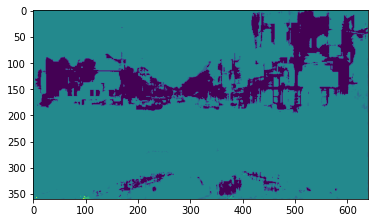

In [ ]:
plt.imshow(pred_argx)

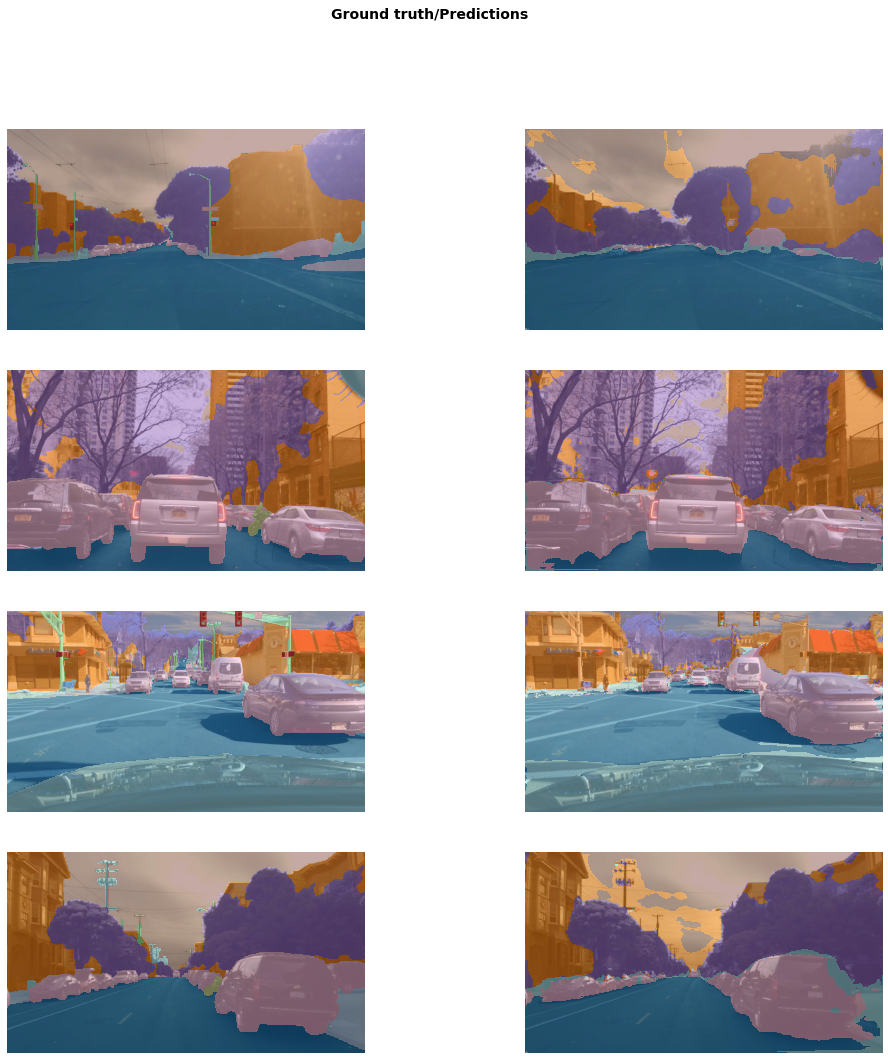

In [ ]:
imgs=learn.show_results(rows=5,figsize=(17,17))